# 平面数据分类

构建具有单隐藏层的2类分类神经网络.

使用具有非线性激活功能激活函数，例如tanh。

计算交叉熵损失（损失函数）。

实现向前和向后传播。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) #设置一个固定的随机种子

## 加载、查看数据

In [2]:
# 加载一个花的图案的2类数据集

X, Y = load_planar_dataset()

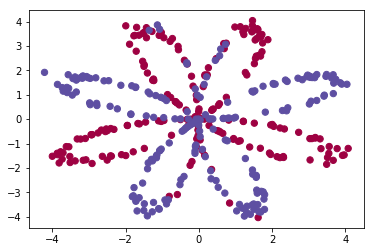

In [3]:
plt.scatter(X[0,:], X[1,:], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)

数据看起来像一朵红色（y = 0）和一些蓝色（y = 1）的数据点的花朵的图案。 

目标是建立一个模型来适应这些数据。

X：一个numpy的矩阵，包含了这些数据点的数值

Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）

In [4]:
print ("X的维度为: " + str(X.shape))
print ("Y的维度为: " + str(Y.shape))
print ("数据集里面的数据有：" + str(Y.shape[1]) + " 个")

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


## 简单的逻辑回归分类

使用sklearn的内置函数， 训练数据集上的逻辑回归分类器

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)

E:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


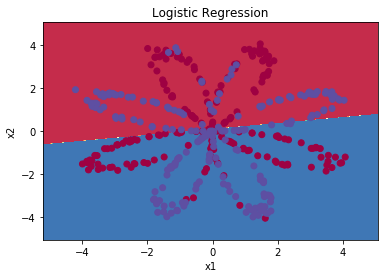

In [6]:
plot_decision_boundary(lambda x: clf.predict(x), X, np.squeeze(Y))    # 决策边界
plt.title("Logistic Regression")
LR_predictions  = clf.predict(X.T)


print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
                                np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

准确性只有47%的原因是数据集不是线性可分的，所以逻辑回归表现不佳

## 搭建神经网络

搭建如下神经网络

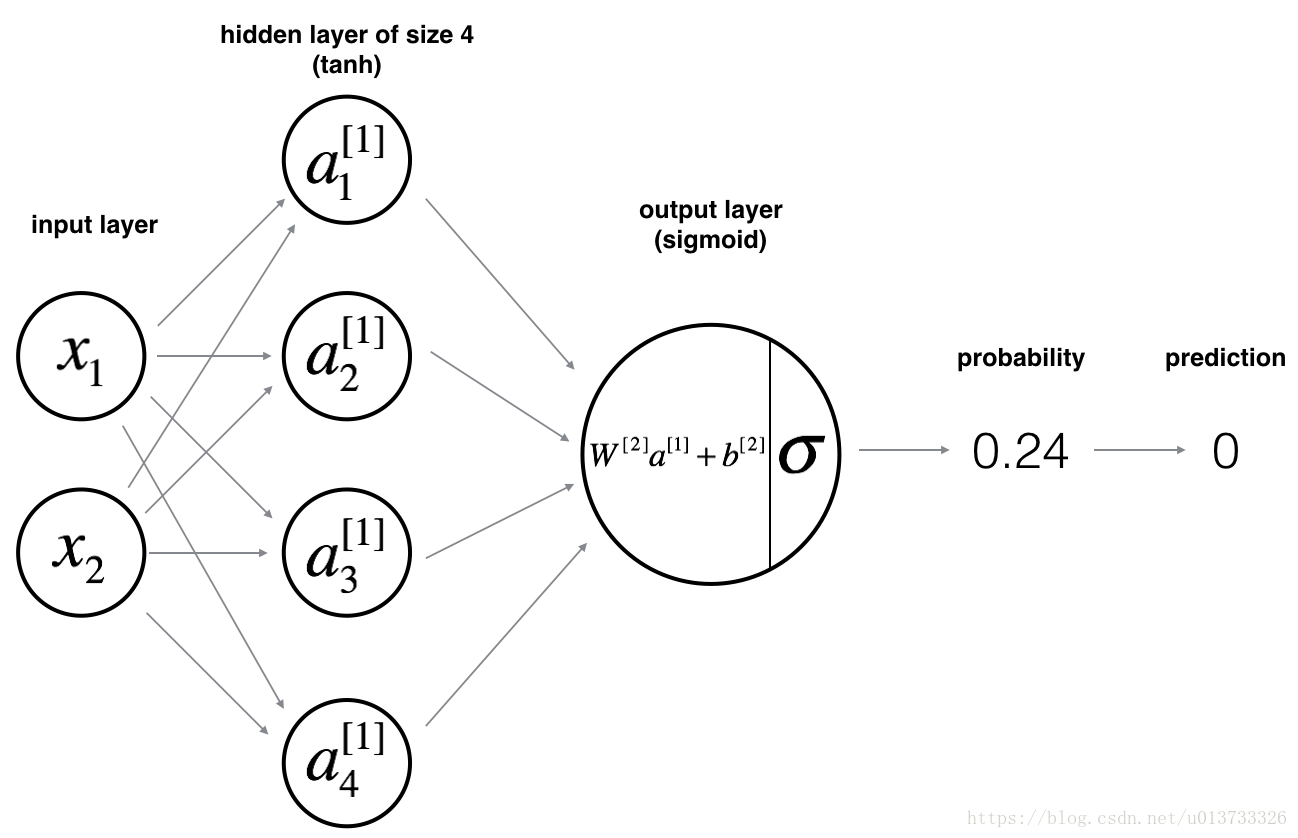

$\text z^{[1](i)}=W^{[1]T}x^{(i)}+b^{[1]}$

$\text a^{[1](i)}=tanh(z^{[1](i)})$

$\text z^{[2](i)}=W^{[1]T}a^{[1](i)}+b^{[2]}$

$\textŷ^{(i)}=a^{[2](i)}=sigmoid(z^{(i)})$

$\text J=-\frac{1}{m}(y log(a^{[2](i)})+(1-y^{(i)}) log(1-a^{[2](i)})$

构建神经网络的一般方法是：

1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。
2. 初始化模型的参数
3. 循环：实施前向传播、计算损失、实现向后传播、更新参数（梯度下降）

### 定义神经网络

In [4]:
def layer_sizes(X, Y):
    
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）
    
    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    
    return n_x, n_h, n_y

In [5]:
# 测试
print("测试：")
X_asses, Y_asses = layer_sizes_test_case()
n_x, n_h, n_y = layer_sizes(X_asses, Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

测试：
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


### 初始化模型参数

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    
    np.random.seed(2)  # 指定一个随机种子
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    # 使用断言保证格式正确
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2
                 }
    
    return parameters

In [12]:
# 测试
print("测试：")
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

测试：
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


### 循环
#### 前向传播

$$\text z^{[1](i)}=W^{[1]T}x^{(i)}+b^{[1]}$$
$$\text a^{[1](i)}=tanh(z^{[1](i)})$$
$$\text z^{[2](i)}=W^{[1]T}a^{[1](i)}+b^{[2]}$$

In [6]:
def forward_propagation(X, parameters):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    
    #使用断言确保数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2
            }
    
    return (A2, cache)

In [22]:
print("测试forward_propagation：")
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))

测试forward_propagation：
-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


#### 计算损失
$$\text J=-\frac{1}{m}(y^{(i)} log(a^{[2](i)})+(1-y^{(i)}) log(1-a^{[2](i)})$$

In [7]:
def compute_cost(A2, Y, parameters):
    
    """
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本 - 交叉熵成本给出方程（13）
    """
    
    m = Y.shape[1]
    
    # np.multiply:数组和矩阵对应位置相乘，输出与相乘数组/矩阵的大小一致
    J = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    J = - np.sum(J) / m
    cost = float(np.squeeze(J))
    
    assert(isinstance(cost,float))
    
    return cost

In [20]:
print("测试compute_cost：")
A2, Y_assess, parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

测试compute_cost：
cost = 0.6929198937761266


#### 反向传播

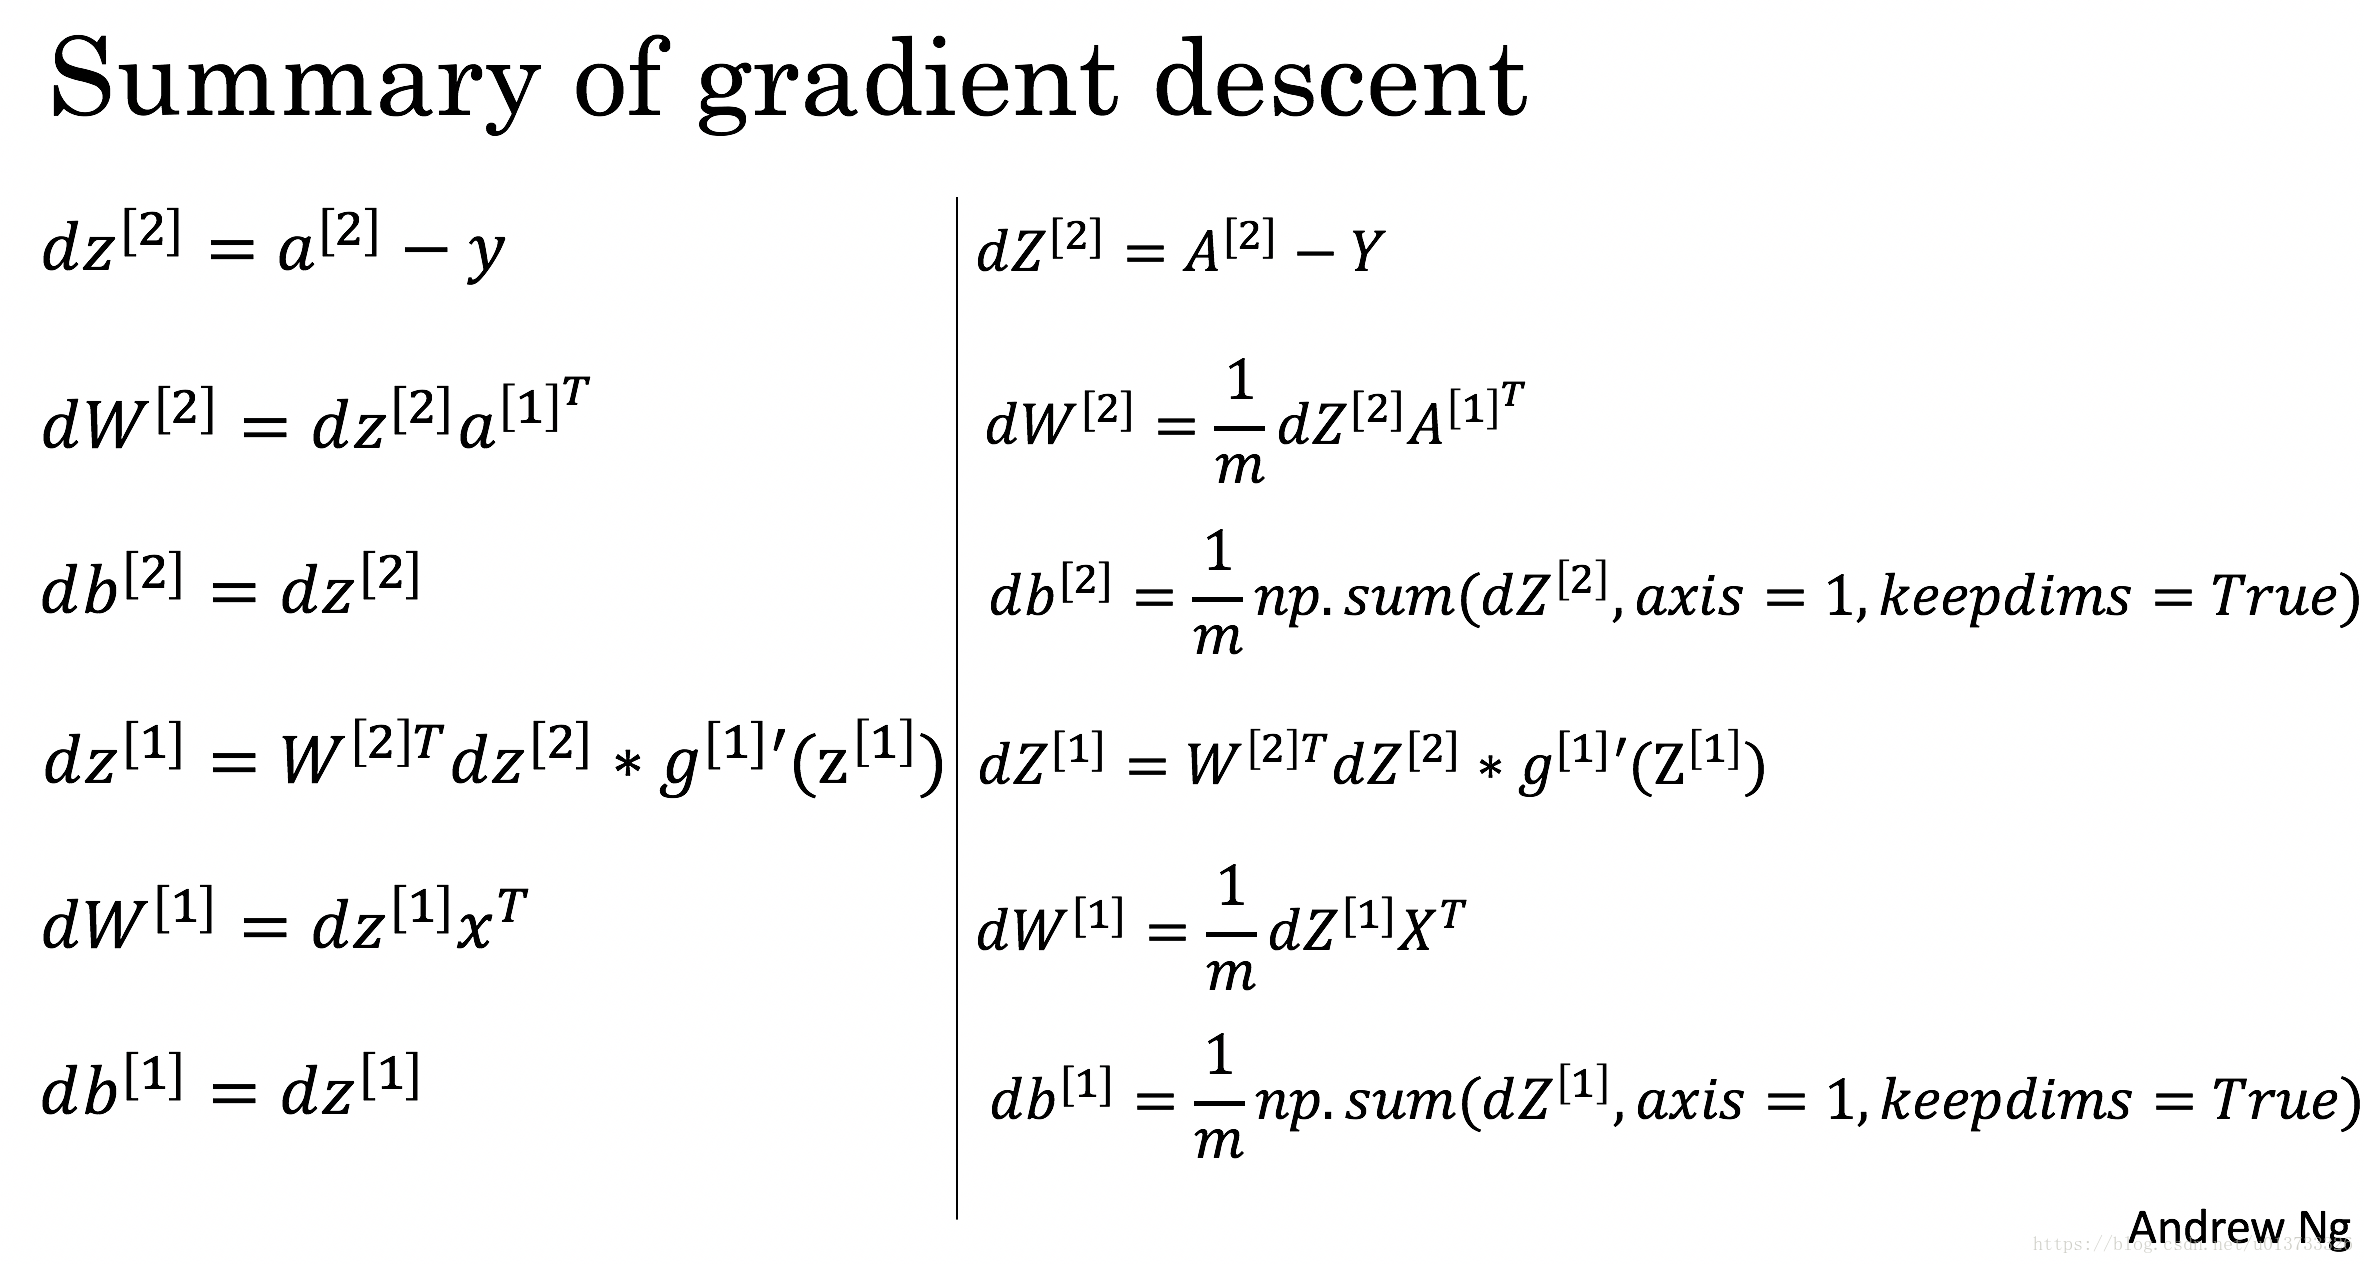

In [8]:
def backward_propagation(parameters, cache, X, Y):
    """
    使用上述说明搭建反向传播函数。
    
    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    W2 = parameters["W2"]
    
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    return grads

In [22]:
print("测试backward_propagation：")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
grads = backward_propagation(parameters, cache, X_assess, Y_assess)

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

测试backward_propagation：
dW1 = [[ 0.03056125 -0.02126104]
 [ 0.02620342 -0.0182304 ]
 [-0.0159254   0.01108138]
 [-0.06619094  0.04605379]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


#### 更新参数
用(dW1, db1, dW2, db2)来更新(W1, b1, W2, b2)

更新算法如下：
$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$

In [9]:
def update_parameters(parameters, grads, learning_rate):
    """
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    
    dW1, db1, dW2, db2 = grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

In [13]:
print("测试update_parameters：")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, learning_rate=1.2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

测试update_parameters：
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


#### 整合

In [10]:
def nn_model(X, Y, n_h, num_iterations, print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，400）
        Y - 标签，维度为（1，400）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
    np.random.seed(3)
    
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
                
    return parameters

In [25]:
print("测试nn_model：")
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

测试nn_model：


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
E:\Python\jupyter-notebook\course1\week3-带有一个隐藏层的平面数据分类\planar_utils.py:25: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-4.25609331  5.4369868 ]
 [-7.56377327  1.12185467]
 [-4.15090629  5.53269008]
 [ 7.56704013 -1.12167264]]
b1 = [[ 1.61969788]
 [ 3.15672261]
 [ 1.59967069]
 [-3.15460507]]
W2 = [[-2514.22438915 -2503.13650616 -2512.1829801   2503.26465951]]
b2 = [[-22.0008197]]


## 预测

In [11]:
def predict(parameters, X):
    """
    使用学习的参数，为X中的每个示例预测一个类
    
    参数：
        parameters - 包含参数的字典类型的变量。
        X - 输入数据（n_x，m）
    
    返回:
        predictions - 我们模型预测的向量（红色：0 /蓝色：1）
     
     """
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

In [27]:
print("测试nn_model：")

parameters, X_assess = predict_test_case()
predictions = predict(parameters, X)

print("预测的平均值 = " + str(np.mean(predictions)))

测试nn_model：
预测的平均值 = 0.4925


## 运行

第  0  次循环，成本为：0.6930480201239823
第  1000  次循环，成本为：0.5375863939697437
第  2000  次循环，成本为：0.5322074398976272
第  3000  次循环，成本为：0.5298308315483381
第  4000  次循环，成本为：0.5282756196110344
第  5000  次循环，成本为：0.5269465660418414
第  6000  次循环，成本为：0.5258415500954738
第  7000  次循环，成本为：0.5248592882294675
第  8000  次循环，成本为：0.5239688908209699
第  9000  次循环，成本为：0.41439712724347133
准确率: 73%


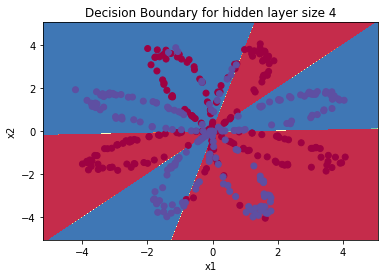

In [12]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

### 更改隐藏节点

隐藏层的节点数量： 1  ，准确率: 68.25 %
隐藏层的节点数量： 2  ，准确率: 68.25 %
隐藏层的节点数量： 3  ，准确率: 68.5 %
隐藏层的节点数量： 4  ，准确率: 72.5 %
隐藏层的节点数量： 5  ，准确率: 69.0 %
隐藏层的节点数量： 20  ，准确率: 92.75 %


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


隐藏层的节点数量： 50  ，准确率: 93.75 %


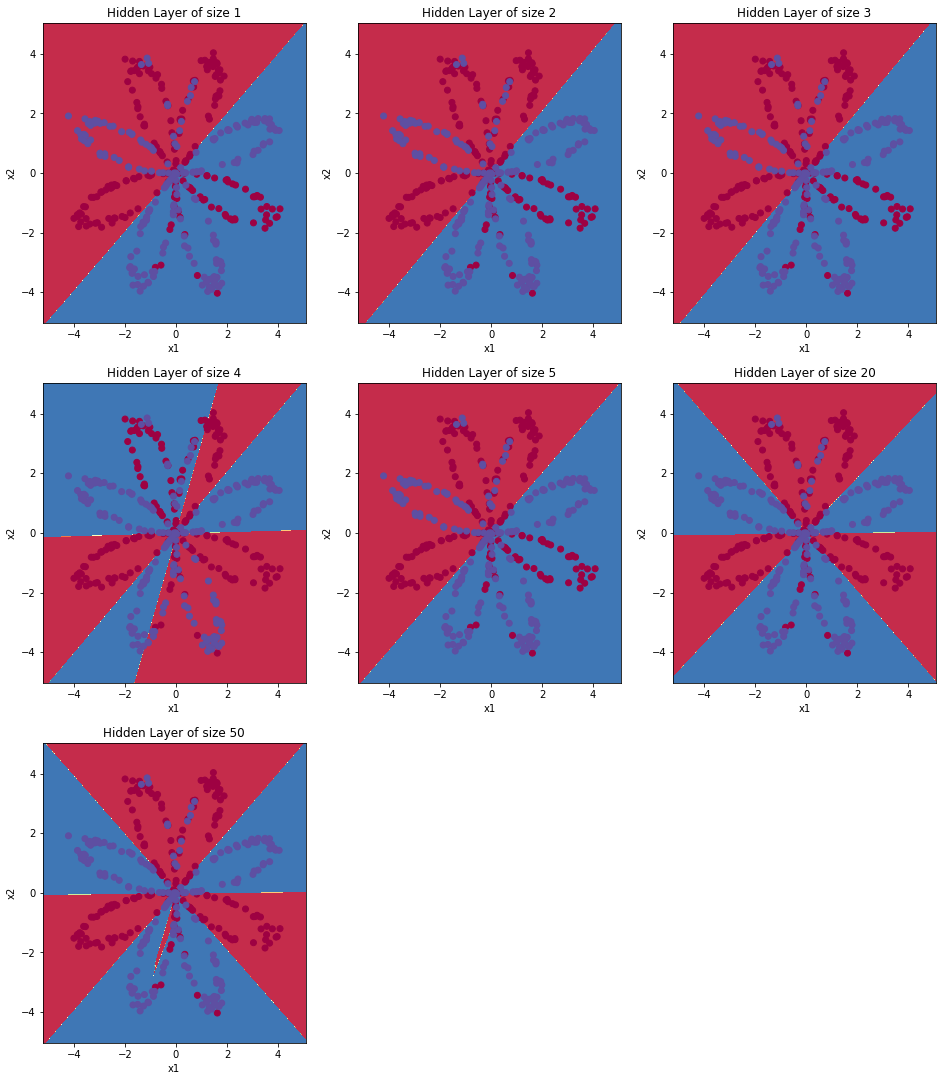

In [17]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=50000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))